<h1>Abgabe</h1>

In [1]:
!pip install yfinance
!pip install pandas

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Start des Trainingsprozesses für AAPL...
               Close  SMA_20  SMA_50    EMA_20    EMA_50  HMA_20  HMA_50
Date                                                                    
2010-01-04  7.643214     NaN     NaN  7.643214  7.643214     NaN     NaN
2010-01-05  7.656429     NaN     NaN  7.644473  7.643732     NaN     NaN
2010-01-06  7.534643     NaN     NaN  7.634013  7.639454     NaN     NaN
2010-01-07  7.520714     NaN     NaN  7.623222  7.634798     NaN     NaN
2010-01-08  7.570714     NaN     NaN  7.618222  7.632285     NaN     NaN

Start des Trainingsprozesses für MSFT...
                Close  SMA_20  SMA_50     EMA_20     EMA_50  HMA_20  HMA_50
Date                                                                       
2010-01-04  30.950001     NaN     NaN  30.950001  30.950001     NaN     NaN
2010-01-05  30.959999     NaN     NaN  30.950953  30.950393     NaN     NaN
2010-01-06  30.770000     NaN     NaN  30.933719  30.943319     NaN     NaN
2010-01-07  30.450001     

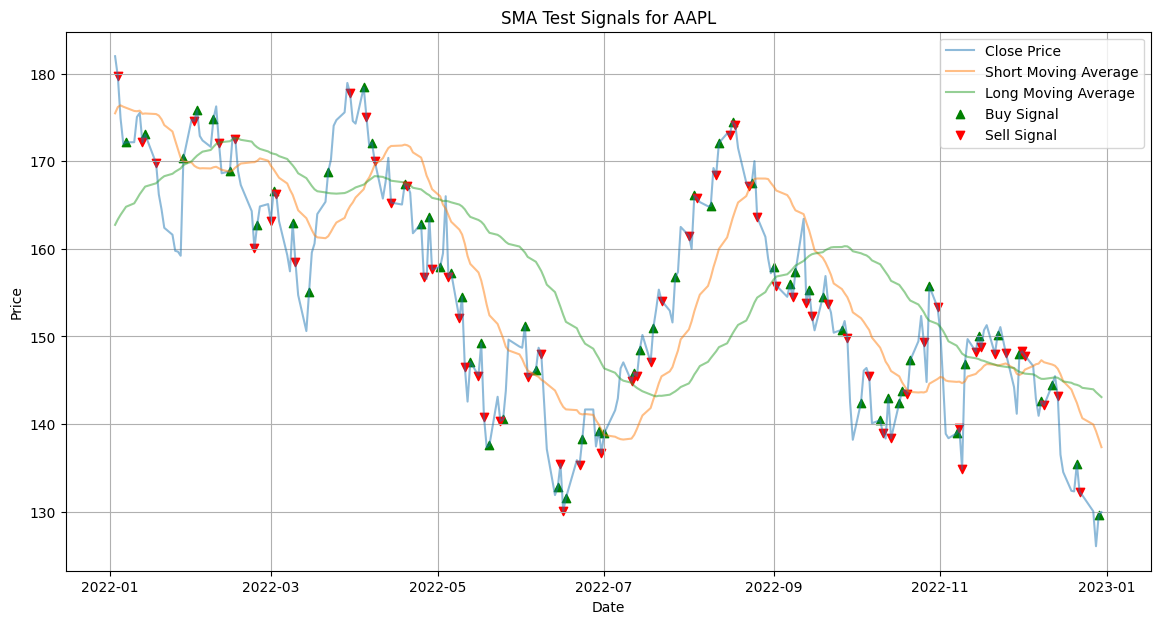

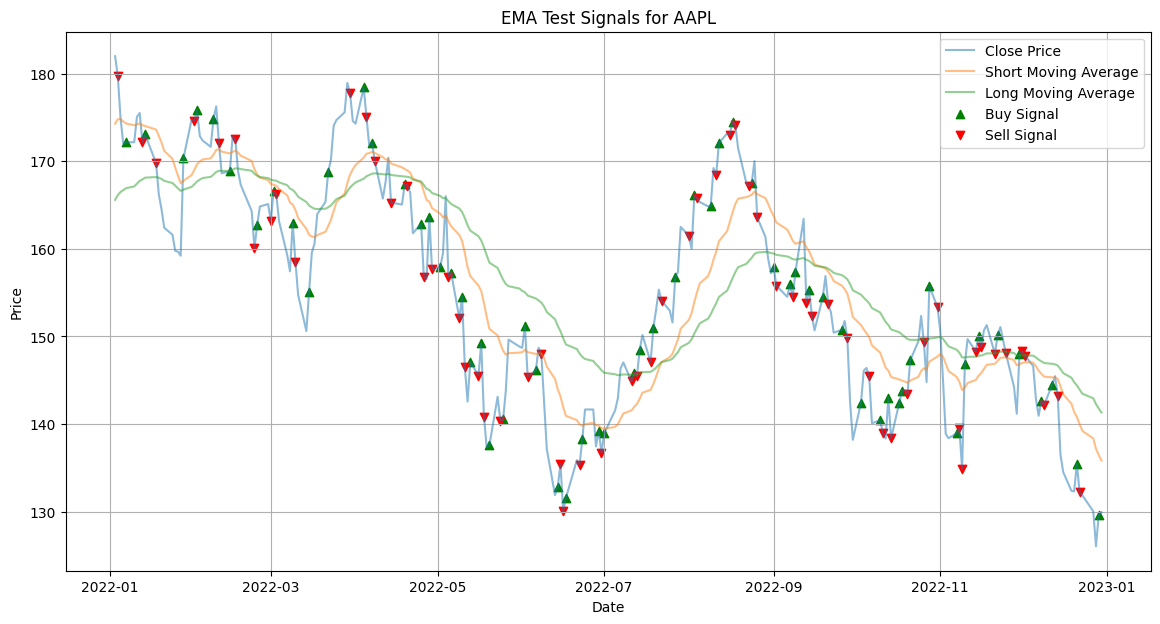

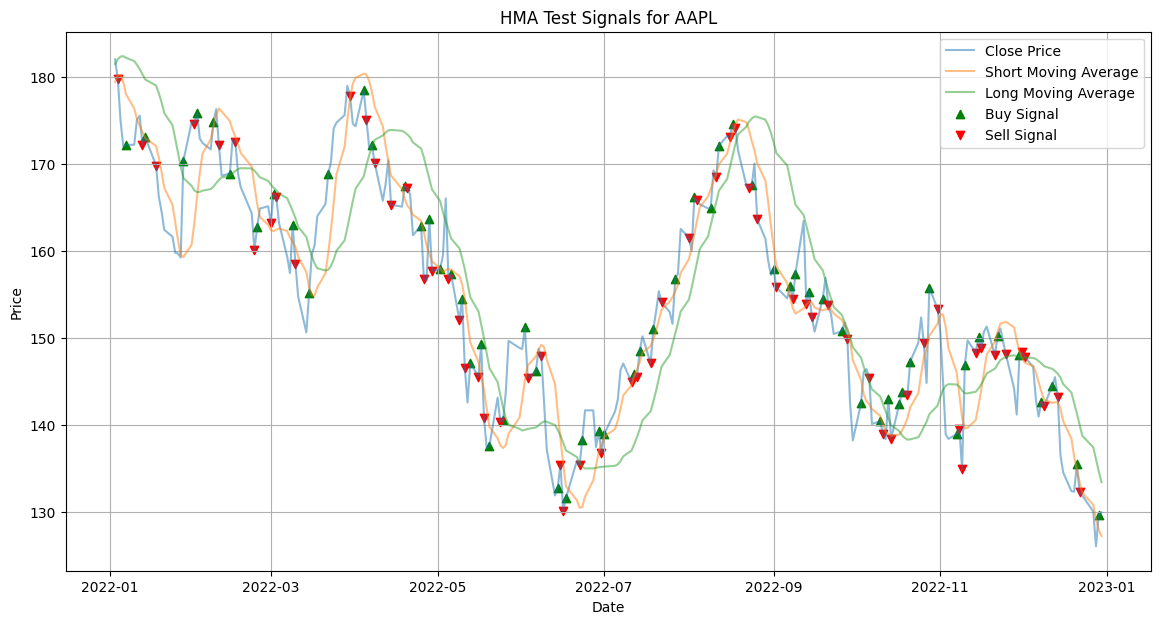

In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Daten von yfinance herunterladen
data_aapl = yf.download("AAPL", start="2010-01-01", end="2022-12-31")
data_msft = yf.download("MSFT", start="2010-01-01", end="2022-12-31")

# Berechnung der gleitenden Durchschnitte
def calculate_moving_averages(data):
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
    data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
    return data

data_aapl = calculate_moving_averages(data_aapl)
data_msft = calculate_moving_averages(data_msft)

# Hull Moving Average (HMA) berechnen
def HMA(data, window):
    half_length = int(window / 2)
    sqrt_length = int(np.sqrt(window))
    WMA_half = data.rolling(window=half_length).apply(lambda x: np.average(x, weights=range(1, half_length + 1)))
    WMA_full = data.rolling(window=window).apply(lambda x: np.average(x, weights=range(1, window + 1)))
    raw_HMA = 2 * WMA_half - WMA_full
    HMA = raw_HMA.rolling(window=sqrt_length).apply(lambda x: np.average(x, weights=range(1, sqrt_length + 1)))
    return HMA

data_aapl['HMA_20'] = HMA(data_aapl['Close'], 20)
data_aapl['HMA_50'] = HMA(data_aapl['Close'], 50)
data_msft['HMA_20'] = HMA(data_msft['Close'], 20)
data_msft['HMA_50'] = HMA(data_msft['Close'], 50)

# Berechnung der Return on Capital (ROC)
data_aapl['ReturnOnCapital'] = data_aapl['Close'].pct_change() * 100
data_msft['ReturnOnCapital'] = data_msft['Close'].pct_change() * 100

# Funktion zur Generierung von Kauf- und Verkaufssignalen
def generate_signals(data, short_window, long_window, ma_type):
    data['Signal'] = 0
    if ma_type == 'SMA':
        short_ma = data[f'SMA_{short_window}']
        long_ma = data[f'SMA_{long_window}']
    elif ma_type == 'EMA':
        short_ma = data[f'EMA_{short_window}']
        long_ma = data[f'EMA_{long_window}']
    elif ma_type == 'HMA':
        short_ma = data[f'HMA_{short_window}']
        long_ma = data[f'HMA_{long_window}']
    else:
        raise ValueError("Unknown moving average type")

    data.loc[(short_ma > long_ma) & (data['ReturnOnCapital'] > 0), 'Signal'] = 1
    data.loc[(short_ma < long_ma) & (data['ReturnOnCapital'] < 0), 'Signal'] = -1

    data['Position'] = data['Signal'].diff()
    return data

# Trainingszeitraum festlegen (aktuell bis vor einem Jahr)
train_data_aapl = data_aapl['2010-01-01':'2021-12-31'].copy()
train_data_msft = data_msft['2010-01-01':'2021-12-31'].copy()

# Trainingsprozess anzeigen
print("Start des Trainingsprozesses für AAPL...")
print(train_data_aapl[['Close', 'SMA_20', 'SMA_50', 'EMA_20', 'EMA_50', 'HMA_20', 'HMA_50']].head())
print("\nStart des Trainingsprozesses für MSFT...")
print(train_data_msft[['Close', 'SMA_20', 'SMA_50', 'EMA_20', 'EMA_50', 'HMA_20', 'HMA_50']].head())

# Signale generieren
train_data_aapl = generate_signals(train_data_aapl, 20, 50, 'SMA')
train_data_aapl = generate_signals(train_data_aapl, 20, 50, 'EMA')
train_data_aapl = generate_signals(train_data_aapl, 20, 50, 'HMA')

train_data_msft = generate_signals(train_data_msft, 20, 50, 'SMA')
train_data_msft = generate_signals(train_data_msft, 20, 50, 'EMA')
train_data_msft = generate_signals(train_data_msft, 20, 50, 'HMA')

# Kombiniertes Trainingsset erstellen
train_data_combined = pd.concat([train_data_aapl, train_data_msft])

# Testsignale generieren
test_data_aapl = data_aapl['2022-01-01':].copy()

test_data_aapl = generate_signals(test_data_aapl, 20, 50, 'SMA')
test_data_aapl = generate_signals(test_data_aapl, 20, 50, 'EMA')
test_data_aapl = generate_signals(test_data_aapl, 20, 50, 'HMA')

# Testsignale visualisieren
def plot_signals(data, ma_type, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='Close Price', alpha=0.5)
    plt.plot(data[f'{ma_type}_20'], label='Short Moving Average', alpha=0.5)
    plt.plot(data[f'{ma_type}_50'], label='Long Moving Average', alpha=0.5)

    buy_signals = data.loc[data['Position'] == 1].index
    sell_signals = data.loc[data['Position'] == -1].index

    plt.scatter(buy_signals, data.loc[buy_signals, 'Close'], label='Buy Signal', marker='^', color='green', alpha=1)
    plt.scatter(sell_signals, data.loc[sell_signals, 'Close'], label='Sell Signal', marker='v', color='red', alpha=1)

    plt.title(f'{ma_type} Test Signals for {title}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

# Testsignale für SMA, EMA und HMA plotten
plot_signals(test_data_aapl, 'SMA', 'AAPL')
plot_signals(test_data_aapl, 'EMA', 'AAPL')
plot_signals(test_data_aapl, 'HMA', 'AAPL')
